In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

In [26]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    s2 = Q/N
    vs2 = s2/N
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    vB = (1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr)/tmp
    return s2,vs2,B,vB

def OUresult(data,deltat):
    s2, vs2, B ,vB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*np.sqrt(vB)/B/np.log(B)**2
    return s2,np.sqrt(vs2),tau,dtau

In [27]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [28]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

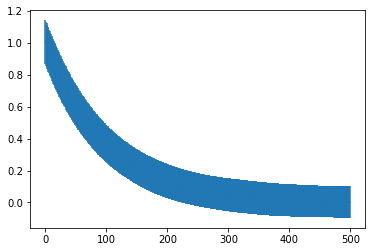

In [29]:
plt.errorbar(t,acf_mean,yerr=acf_std)

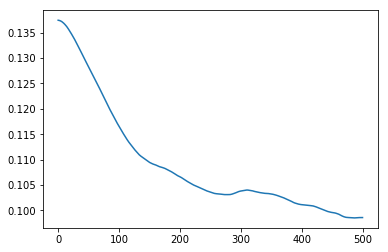

In [30]:
plt.plot(t,acf_std)

In [31]:
acf_all[0].size

500

In [40]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            np.sqrt(out.covar[1,1])*delta_t,
                            out.values['amplitude'],
                            np.sqrt(out.covar[0,0])])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            np.sqrt(out2.covar[1,1])*delta_t,
                            out2.values['amplitude'],
                            np.sqrt(out2.covar[0,0])])
        print(out2.fit_report(min_correl=0.25))

    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 500
    # variables        = 2
    chi-square         = 0.891
    reduced chi-square = 0.002
    Akaike info crit   = -3158.960
    Bayesian info crit = -3150.531
[[Variables]]
    amplitude:   0.87369671 +/- 0.009685 (1.11%) (init= 0.6218333)
    decay:       74.2862513 +/- 1.172609 (1.58%) (init= 92.98307)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 78.328
    reduced chi-square = 0.157
    Akaike info crit   = -920.850
    Bayesian info crit = -912.421
[[Variables]]
    amplitude:   0.89038257 +/- 0.012143 (1.36%) (init= 0.6218333)
    decay:       72.1075203 +/- 1.253989 (1.74%) (init= 92.98307)
[[Correlations]] (unreported correlations a


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 346.020
    reduced chi-square = 0.695
    Akaike info crit   = -178.052
    Bayesian info crit = -169.623
[[Variables]]
    amplitude:   1.08745272 +/- 0.023086 (2.12%) (init= 0.4356278)
    decay:       87.4419437 +/- 2.340809 (2.68%) (init= 234.714)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.714 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 8.635
    reduced chi-square = 0.017
    Akaike info crit   = -2023.372
    Bayesian info crit = -2014.943
[[Variables]]
    amplitude:   1.34249666 +/- 0.027031 (2.01%) (init= 0.6583408)
    decay:       92.9923997 +/- 2.664695 (2.87%) (init= 217.2314)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 262.910
    reduced chi-square = 0.528
    Akaike info crit   = -315.394
    Bayesian info crit = -306.965
[[Variables]]
    amplitude:   0.76054595 +/- 0.017852 (2.35%) (init= 0.3038273)
    decay:       110.023441 +/- 3.235812 (2.94%) (init= 352.5625)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.722 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 3.106
    reduced chi-square = 0.006
    Akaike info crit   = -2534.575
    Bayesian info crit = -2526.146
[[Variables]]
    amplitude:   0.89254753 +/- 0.012733 (1.43%) (init= 0.5248549)
    decay:       155.973444 +/- 3.229438 (2.07%) (init= 318.0006)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 1.382
    reduced chi-square = 0.003
    Akaike info crit   = -2939.513
    Bayesian info crit = -2931.084
[[Variables]]
    amplitude:   1.12193925 +/- 0.013302 (1.19%) (init= 0.2119453)
    decay:       60.7038833 +/- 1.026437 (1.69%) (init= 183.8991)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.701 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 115.787
    reduced chi-square = 0.233
    Akaike info crit   = -725.422
    Bayesian info crit = -716.993
[[Variables]]
    amplitude:   1.14426764 +/- 0.016439 (1.44%) (init= 0.2119453)
    decay:       58.5402430 +/- 1.089272 (1.86%) (init= 183.8991)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.553
    reduced chi-square = 0.001
    Akaike info crit   = -3397.328
    Bayesian info crit = -3388.899
[[Variables]]
    amplitude:   1.02101685 +/- 0.005168 (0.51%) (init= 0.8462857)
    decay:       170.804571 +/- 1.269164 (0.74%) (init= 214.3125)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.717 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 46.834
    reduced chi-square = 0.094
    Akaike info crit   = -1177.994
    Bayesian info crit = -1169.565
[[Variables]]
    amplitude:   1.00178203 +/- 0.005983 (0.60%) (init= 0.8462857)
    decay:       175.382851 +/- 1.357263 (0.77%) (init= 214.3125)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 1.057
    reduced chi-square = 0.002
    Akaike info crit   = -3073.616
    Bayesian info crit = -3065.187
[[Variables]]
    amplitude:   0.96229067 +/- 0.006566 (0.68%) (init= 0.8997269)
    decay:       211.209980 +/- 2.205369 (1.04%) (init= 233.0869)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.729 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 74.262
    reduced chi-square = 0.149
    Akaike info crit   = -947.503
    Bayesian info crit = -939.074
[[Variables]]
    amplitude:   0.93930735 +/- 0.006844 (0.73%) (init= 0.8997269)
    decay:       218.674145 +/- 2.176956 (1.00%) (init= 233.0869)
[[Correlations]] (unreported correlations a


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.040
    reduced chi-square = 0.004
    Akaike info crit   = -2744.801
    Bayesian info crit = -2736.372
[[Variables]]
    amplitude:   1.09896365 +/- 0.013092 (1.19%) (init= 0.6457847)
    decay:       93.6889328 +/- 1.588060 (1.70%) (init= 151.4268)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 189.983
    reduced chi-square = 0.381
    Akaike info crit   = -477.834
    Bayesian info crit = -469.404
[[Variables]]
    amplitude:   1.11811259 +/- 0.016701 (1.49%) (init= 0.6457847)
    decay:       91.5367941 +/- 1.721124 (1.88%) (init= 151.4268)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 54
    # data points      = 500
    # variables        = 2
    chi-square         = 477.779
    reduced chi-square = 0.959
    Akaike info crit   = -16.726
    Bayesian info crit = -8.297
[[Variables]]
    amplitude:   1.16913663 +/- 0.034927 (2.99%) (init= 0.2545935)
    decay:       53.6236763 +/- 2.089955 (3.90%) (init= 368.169)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 58
    # data points      = 500
    # variables        = 2
    chi-square         = 4.647
    reduced chi-square = 0.009
    Akaike info crit   = -2333.193
    Bayesian info crit = -2324.764
[[Variables]]
    amplitude:   0.75978744 +/- 0.020658 (2.72%) (init= 0.2218912)
    decay:       85.4696703 +/- 3.307634 (3.87%) (init= 554.7759)
[[Correlations]] (unreported correlations are 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.434
    reduced chi-square = 0.003
    Akaike info crit   = -2921.093
    Bayesian info crit = -2912.664
[[Variables]]
    amplitude:   1.16505700 +/- 0.011065 (0.95%) (init= 0.492971)
    decay:       92.1381653 +/- 1.245127 (1.35%) (init= 188.8357)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 131.396
    reduced chi-square = 0.264
    Akaike info crit   = -662.193
    Bayesian info crit = -653.764
[[Variables]]
    amplitude:   1.16995646 +/- 0.013912 (1.19%) (init= 0.492971)
    decay:       91.2572768 +/- 1.365934 (1.50%) (init= 188.8357)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude,

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 0.878
    reduced chi-square = 0.002
    Akaike info crit   = -3166.604
    Bayesian info crit = -3158.175
[[Variables]]
    amplitude:   1.03730513 +/- 0.007491 (0.72%) (init= 1.527652)
    decay:       124.650474 +/- 1.286683 (1.03%) (init= 83.00748)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.707 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 80.254
    reduced chi-square = 0.161
    Akaike info crit   = -908.702
    Bayesian info crit = -900.273
[[Variables]]
    amplitude:   1.04495249 +/- 0.009286 (0.89%) (init= 1.527652)
    decay:       123.710691 +/- 1.378403 (1.11%) (init= 83.00748)
[[Correlations]] (unreported correlations are


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 121.099
    reduced chi-square = 0.243
    Akaike info crit   = -702.994
    Bayesian info crit = -694.565
[[Variables]]
    amplitude:   1.26590438 +/- 0.012966 (1.02%) (init= 0.8361024)
    decay:       96.5928383 +/- 1.242611 (1.29%) (init= 118.974)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.717 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 5.130
    reduced chi-square = 0.010
    Akaike info crit   = -2283.753
    Bayesian info crit = -2275.324
[[Variables]]
    amplitude:   0.80012774 +/- 0.012083 (1.51%) (init= 0.6756381)
    decay:       376.342639 +/- 11.02765 (2.93%) (init= 525.4986)
[[Correlations]] (unreported correlations 


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 170.340
    reduced chi-square = 0.342
    Akaike info crit   = -532.403
    Bayesian info crit = -523.973
[[Variables]]
    amplitude:   1.25380218 +/- 0.017327 (1.38%) (init= 0.6090152)
    decay:       76.8181686 +/- 1.348484 (1.76%) (init= 127.601)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.710 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 0.884
    reduced chi-square = 0.002
    Akaike info crit   = -3163.201
    Bayesian info crit = -3154.772
[[Variables]]
    amplitude:   1.08706815 +/- 0.008294 (0.76%) (init= 0.7312586)
    decay:       101.340119 +/- 1.100697 (1.09%) (init= 121.7419)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 2.164
    reduced chi-square = 0.004
    Akaike info crit   = -2715.232
    Bayesian info crit = -2706.803
[[Variables]]
    amplitude:   1.14464596 +/- 0.012350 (1.08%) (init= 0.9107077)
    decay:       112.442250 +/- 1.729414 (1.54%) (init= 116.9561)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 190.603
    reduced chi-square = 0.383
    Akaike info crit   = -476.203
    Bayesian info crit = -467.773
[[Variables]]
    amplitude:   1.17306048 +/- 0.015282 (1.30%) (init= 0.9107077)
    decay:       108.911500 +/- 1.777306 (1.63%) (init= 116.9561)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.384
    reduced chi-square = 0.001
    Akaike info crit   = -3580.401
    Bayesian info crit = -3571.971
[[Variables]]
    amplitude:   0.98149548 +/- 0.006486 (0.66%) (init= 0.2780121)
    decay:       71.2061720 +/- 0.670217 (0.94%) (init= 162.4169)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 35.568
    reduced chi-square = 0.071
    Akaike info crit   = -1315.572
    Bayesian info crit = -1307.143
[[Variables]]
    amplitude:   0.98590847 +/- 0.008272 (0.84%) (init= 0.2780121)
    decay:       70.6009946 +/- 0.756524 (1.07%) (init= 162.4169)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 426.566
    reduced chi-square = 0.857
    Akaike info crit   = -73.416
    Bayesian info crit = -64.987
[[Variables]]
    amplitude:   0.99472028 +/- 0.029865 (3.00%) (init= 0.3776163)
    decay:       65.1650536 +/- 2.511849 (3.85%) (init= 222.3695)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.706 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 1.265
    reduced chi-square = 0.003
    Akaike info crit   = -2983.819
    Bayesian info crit = -2975.390
[[Variables]]
    amplitude:   0.82754863 +/- 0.008847 (1.07%) (init= 0.5423684)
    decay:       129.117704 +/- 1.975900 (1.53%) (init= 199.5327)
[[Correlations]] (unreported correlations ar

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 358.183
    reduced chi-square = 0.719
    Akaike info crit   = -160.778
    Bayesian info crit = -152.349
[[Variables]]
    amplitude:   1.17452339 +/- 0.025003 (2.13%) (init= 0.3517122)
    decay:       77.5411480 +/- 2.095782 (2.70%) (init= 247.6709)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.710 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 1.107
    reduced chi-square = 0.002
    Akaike info crit   = -3050.689
    Bayesian info crit = -3042.260
[[Variables]]
    amplitude:   1.05875578 +/- 0.007901 (0.75%) (init= 1.140106)
    decay:       142.832549 +/- 1.535189 (1.07%) (init= 132.9107)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 0.583
    reduced chi-square = 0.001
    Akaike info crit   = -3370.878
    Bayesian info crit = -3362.449
[[Variables]]
    amplitude:   1.10747350 +/- 0.007191 (0.65%) (init= 0.5425411)
    decay:       88.6185860 +/- 0.818848 (0.92%) (init= 112.9005)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 48.455
    reduced chi-square = 0.097
    Akaike info crit   = -1160.977
    Bayesian info crit = -1152.548
[[Variables]]
    amplitude:   1.12259132 +/- 0.008679 (0.77%) (init= 0.5425411)
    decay:       86.6676366 +/- 0.845408 (0.98%) (init= 112.9005)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.388
    reduced chi-square = 0.001
    Akaike info crit   = -3575.194
    Bayesian info crit = -3566.765
[[Variables]]
    amplitude:   0.82086770 +/- 0.006762 (0.82%) (init= 0.2609729)
    decay:       66.0590945 +/- 0.775481 (1.17%) (init= 150.4517)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 35.253
    reduced chi-square = 0.071
    Akaike info crit   = -1320.024
    Bayesian info crit = -1311.595
[[Variables]]
    amplitude:   0.82872724 +/- 0.008599 (1.04%) (init= 0.2609729)
    decay:       64.9370324 +/- 0.865732 (1.33%) (init= 150.4517)
[[Correlations]] (unreported correlations


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 18.589
    reduced chi-square = 0.037
    Akaike info crit   = -1640.025
    Bayesian info crit = -1631.596
[[Variables]]
    amplitude:   0.93214630 +/- 0.005178 (0.56%) (init= 0.7027217)
    decay:       93.1039696 +/- 0.650506 (0.70%) (init= 118.291)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.716 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 0.741
    reduced chi-square = 0.001
    Akaike info crit   = -3251.470
    Bayesian info crit = -3243.041
[[Variables]]
    amplitude:   0.92358847 +/- 0.007573 (0.82%) (init= 0.6175557)
    decay:       101.905939 +/- 1.189500 (1.17%) (init= 139.2325)
[[Correlations]] (unreported correlations


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 113.244
    reduced chi-square = 0.227
    Akaike info crit   = -736.528
    Bayesian info crit = -728.098
[[Variables]]
    amplitude:   1.19208687 +/- 0.012634 (1.06%) (init= 0.6948969)
    decay:       95.1888228 +/- 1.267866 (1.33%) (init= 152.5923)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.716 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 3.059
    reduced chi-square = 0.006
    Akaike info crit   = -2542.325
    Bayesian info crit = -2533.896
[[Variables]]
    amplitude:   1.02332482 +/- 0.016488 (1.61%) (init= 0.4380352)
    decay:       88.4099022 +/- 2.026754 (2.29%) (init= 229.5985)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 1.598
    reduced chi-square = 0.003
    Akaike info crit   = -2866.876
    Bayesian info crit = -2858.447
[[Variables]]
    amplitude:   0.96013950 +/- 0.013782 (1.44%) (init= 0.5258114)
    decay:       65.5510580 +/- 1.341063 (2.05%) (init= 112.2541)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 143.598
    reduced chi-square = 0.288
    Akaike info crit   = -617.790
    Bayesian info crit = -609.360
[[Variables]]
    amplitude:   0.97824898 +/- 0.017550 (1.79%) (init= 0.5258114)
    decay:       63.5599360 +/- 1.467127 (2.31%) (init= 112.2541)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 0.475
    reduced chi-square = 0.001
    Akaike info crit   = -3473.096
    Bayesian info crit = -3464.666
[[Variables]]
    amplitude:   0.95510752 +/- 0.006498 (0.68%) (init= 0.5453467)
    decay:       88.4594360 +/- 0.856404 (0.97%) (init= 152.132)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 42.219
    reduced chi-square = 0.085
    Akaike info crit   = -1229.863
    Bayesian info crit = -1221.433
[[Variables]]
    amplitude:   0.94504332 +/- 0.007956 (0.84%) (init= 0.5453467)
    decay:       89.7301984 +/- 0.951506 (1.06%) (init= 152.132)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.710
    reduced chi-square = 0.001
    Akaike info crit   = -3272.449
    Bayesian info crit = -3264.020
[[Variables]]
    amplitude:   1.12426092 +/- 0.007983 (0.71%) (init= 0.4652306)
    decay:       87.5319561 +/- 0.884466 (1.01%) (init= 122.5696)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 63.157
    reduced chi-square = 0.127
    Akaike info crit   = -1028.488
    Bayesian info crit = -1020.059
[[Variables]]
    amplitude:   1.13976959 +/- 0.009966 (0.87%) (init= 0.4652306)
    decay:       85.7117188 +/- 0.946070 (1.10%) (init= 122.5696)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitu

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 67.414
    reduced chi-square = 0.135
    Akaike info crit   = -995.873
    Bayesian info crit = -987.444
[[Variables]]
    amplitude:   0.77465188 +/- 0.009558 (1.23%) (init= 0.5490813)
    decay:       98.8512531 +/- 1.530817 (1.55%) (init= 143.6801)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.718 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 1.121
    reduced chi-square = 0.002
    Akaike info crit   = -3044.399
    Bayesian info crit = -3035.970
[[Variables]]
    amplitude:   0.90243701 +/- 0.009389 (1.04%) (init= 0.8224799)
    decay:       100.263789 +/- 1.484845 (1.48%) (init= 117.9706)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 1.032
    reduced chi-square = 0.002
    Akaike info crit   = -3085.707
    Bayesian info crit = -3077.278
[[Variables]]
    amplitude:   0.88017559 +/- 0.010045 (1.14%) (init= 0.3073509)
    decay:       80.1203355 +/- 1.301580 (1.62%) (init= 189.6108)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 100.468
    reduced chi-square = 0.202
    Akaike info crit   = -796.380
    Bayesian info crit = -787.951
[[Variables]]
    amplitude:   0.88967956 +/- 0.013128 (1.48%) (init= 0.3073509)
    decay:       78.8396989 +/- 1.475565 (1.87%) (init= 189.6108)
[[Correlations]] (unreported correlations 


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 166.045
    reduced chi-square = 0.333
    Akaike info crit   = -545.172
    Bayesian info crit = -536.743
[[Variables]]
    amplitude:   0.85957342 +/- 0.016148 (1.88%) (init= 0.3740374)
    decay:       85.8218204 +/- 2.035270 (2.37%) (init= 171.333)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.713 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 4.133
    reduced chi-square = 0.008
    Akaike info crit   = -2391.818
    Bayesian info crit = -2383.389
[[Variables]]
    amplitude:   0.92407043 +/- 0.017512 (1.90%) (init= 0.4445219)
    decay:       106.539351 +/- 2.875852 (2.70%) (init= 277.2945)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.203
    reduced chi-square = 0.004
    Akaike info crit   = -2706.494
    Bayesian info crit = -2698.065
[[Variables]]
    amplitude:   0.99961277 +/- 0.015270 (1.53%) (init= 0.2815014)
    decay:       73.8610323 +/- 1.606392 (2.17%) (init= 251.0473)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 214.668
    reduced chi-square = 0.431
    Akaike info crit   = -416.753
    Bayesian info crit = -408.324
[[Variables]]
    amplitude:   1.01191798 +/- 0.020062 (1.98%) (init= 0.2815014)
    decay:       72.3941407 +/- 1.829549 (2.53%) (init= 251.0473)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 106.228
    reduced chi-square = 0.213
    Akaike info crit   = -768.507
    Bayesian info crit = -760.078
[[Variables]]
    amplitude:   1.02012745 +/- 0.013617 (1.33%) (init= 0.2750953)
    decay:       77.5397400 +/- 1.313901 (1.69%) (init= 171.8423)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.710 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 1.563
    reduced chi-square = 0.003
    Akaike info crit   = -2878.090
    Bayesian info crit = -2869.661
[[Variables]]
    amplitude:   0.96558653 +/- 0.013511 (1.40%) (init= 0.3068631)
    decay:       66.7424021 +/- 1.330479 (1.99%) (init= 176.0901)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 78.368
    reduced chi-square = 0.157
    Akaike info crit   = -920.590
    Bayesian info crit = -912.161
[[Variables]]
    amplitude:   1.08960073 +/- 0.011078 (1.02%) (init= 0.397923)
    decay:       86.0527130 +/- 1.104259 (1.28%) (init= 152.6332)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.713 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 53
    # data points      = 500
    # variables        = 2
    chi-square         = 7.040
    reduced chi-square = 0.014
    Akaike info crit   = -2125.526
    Bayesian info crit = -2117.097
[[Variables]]
    amplitude:   0.95252883 +/- 0.026974 (2.83%) (init= 0.3453669)
    decay:       75.7153077 +/- 3.051862 (4.03%) (init= 316.6769)
[[Correlations]] (unreported correlations ar

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 78.957
    reduced chi-square = 0.159
    Akaike info crit   = -916.847
    Bayesian info crit = -908.418
[[Variables]]
    amplitude:   1.11274051 +/- 0.010916 (0.98%) (init= 0.5149332)
    decay:       89.1565825 +/- 1.102060 (1.24%) (init= 145.2211)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.714 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 0.615
    reduced chi-square = 0.001
    Akaike info crit   = -3343.969
    Bayesian info crit = -3335.540
[[Variables]]
    amplitude:   1.05359862 +/- 0.007223 (0.69%) (init= 0.7690504)
    decay:       92.8234115 +/- 0.905542 (0.98%) (init= 105.6164)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 0.826
    reduced chi-square = 0.002
    Akaike info crit   = -3196.890
    Bayesian info crit = -3188.461
[[Variables]]
    amplitude:   0.74952522 +/- 0.009102 (1.21%) (init= 0.2719519)
    decay:       78.0796263 +/- 1.349634 (1.73%) (init= 177.9861)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 79.489
    reduced chi-square = 0.160
    Akaike info crit   = -913.492
    Bayesian info crit = -905.063
[[Variables]]
    amplitude:   0.74108765 +/- 0.011617 (1.57%) (init= 0.2719519)
    decay:       79.6440794 +/- 1.582176 (1.99%) (init= 177.9861)
[[Correlations]] (unreported correlations a

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 1.582
    reduced chi-square = 0.003
    Akaike info crit   = -2872.069
    Bayesian info crit = -2863.640
[[Variables]]
    amplitude:   1.24353314 +/- 0.009820 (0.79%) (init= 1.2319)
    decay:       131.191196 +/- 1.484336 (1.13%) (init= 138.9724)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.708 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 141.136
    reduced chi-square = 0.283
    Akaike info crit   = -626.437
    Bayesian info crit = -618.008
[[Variables]]
    amplitude:   1.22089203 +/- 0.011799 (0.97%) (init= 1.2319)
    decay:       134.612209 +/- 1.636659 (1.22%) (init= 138.9724)
[[Correlations]] (unreported correlations are < 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 0.556
    reduced chi-square = 0.001
    Akaike info crit   = -3394.645
    Bayesian info crit = -3386.216
[[Variables]]
    amplitude:   1.01706423 +/- 0.006508 (0.64%) (init= 0.7546559)
    decay:       103.693958 +/- 0.944686 (0.91%) (init= 134.3298)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 54.903
    reduced chi-square = 0.110
    Akaike info crit   = -1098.521
    Bayesian info crit = -1090.091
[[Variables]]
    amplitude:   1.01601463 +/- 0.008404 (0.83%) (init= 0.7546559)
    decay:       103.921890 +/- 1.077609 (1.04%) (init= 134.3298)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitu

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 151.487
    reduced chi-square = 0.304
    Akaike info crit   = -591.049
    Bayesian info crit = -582.620
[[Variables]]
    amplitude:   0.92848396 +/- 0.009696 (1.04%) (init= 0.9107628)
    decay:       223.056880 +/- 3.202413 (1.44%) (init= 230.0799)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.765 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 2.220
    reduced chi-square = 0.004
    Akaike info crit   = -2702.498
    Bayesian info crit = -2694.069
[[Variables]]
    amplitude:   0.81015113 +/- 0.012496 (1.54%) (init= 0.7762116)
    decay:       112.689109 +/- 2.477695 (2.20%) (init= 128.3309)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 1.184
    reduced chi-square = 0.002
    Akaike info crit   = -3016.689
    Bayesian info crit = -3008.260
[[Variables]]
    amplitude:   1.10108311 +/- 0.009198 (0.84%) (init= 0.6755048)
    decay:       110.877535 +/- 1.319725 (1.19%) (init= 189.3044)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 106.149
    reduced chi-square = 0.213
    Akaike info crit   = -768.877
    Bayesian info crit = -760.447
[[Variables]]
    amplitude:   1.07205037 +/- 0.011075 (1.03%) (init= 0.6755048)
    decay:       115.266875 +/- 1.491404 (1.29%) (init= 189.3044)
[[Correlations]] (unreported correlations 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 3.249
    reduced chi-square = 0.007
    Akaike info crit   = -2512.114
    Bayesian info crit = -2503.685
[[Variables]]
    amplitude:   0.78403922 +/- 0.012668 (1.62%) (init= 0.5697988)
    decay:       166.302826 +/- 3.929289 (2.36%) (init= 251.5453)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.716 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 271.401
    reduced chi-square = 0.545
    Akaike info crit   = -299.501
    Bayesian info crit = -291.071
[[Variables]]
    amplitude:   0.72629867 +/- 0.014025 (1.93%) (init= 0.5697988)
    decay:       185.988068 +/- 4.707305 (2.53%) (init= 251.5453)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 222.806
    reduced chi-square = 0.447
    Akaike info crit   = -398.149
    Bayesian info crit = -389.720
[[Variables]]
    amplitude:   0.61198068 +/- 0.011875 (1.94%) (init= 0.4333645)
    decay:       217.819433 +/- 5.766773 (2.65%) (init= 356.8221)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.763 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.633
    reduced chi-square = 0.001
    Akaike info crit   = -3330.153
    Bayesian info crit = -3321.724
[[Variables]]
    amplitude:   0.81770720 +/- 0.007979 (0.98%) (init= 0.3901413)
    decay:       77.8171613 +/- 1.080897 (1.39%) (init= 128.826)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 127.936
    reduced chi-square = 0.257
    Akaike info crit   = -675.535
    Bayesian info crit = -667.106
[[Variables]]
    amplitude:   1.01699091 +/- 0.013279 (1.31%) (init= 0.4474743)
    decay:       97.2595162 +/- 1.594674 (1.64%) (init= 221.9048)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.717 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 4.543
    reduced chi-square = 0.009
    Akaike info crit   = -2344.510
    Bayesian info crit = -2336.081
[[Variables]]
    amplitude:   1.31142281 +/- 0.022000 (1.68%) (init= 0.2212325)
    decay:       73.3790270 +/- 1.752795 (2.39%) (init= 282.953)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.125
    reduced chi-square = 0.004
    Akaike info crit   = -2724.332
    Bayesian info crit = -2715.903
[[Variables]]
    amplitude:   1.06729051 +/- 0.015735 (1.47%) (init= 0.3419448)
    decay:       66.9242150 +/- 1.406007 (2.10%) (init= 173.0845)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 186.052
    reduced chi-square = 0.374
    Akaike info crit   = -488.287
    Bayesian info crit = -479.858
[[Variables]]
    amplitude:   1.09109841 +/- 0.019829 (1.82%) (init= 0.3419448)
    decay:       64.4662709 +/- 1.506257 (2.34%) (init= 173.0845)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 4.281
    reduced chi-square = 0.009
    Akaike info crit   = -2374.214
    Bayesian info crit = -2365.784
[[Variables]]
    amplitude:   1.17452059 +/- 0.016525 (1.41%) (init= 0.564191)
    decay:       124.980053 +/- 2.513435 (2.01%) (init= 206.9898)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.707 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 422.511
    reduced chi-square = 0.848
    Akaike info crit   = -78.192
    Bayesian info crit = -69.763
[[Variables]]
    amplitude:   1.15924671 +/- 0.020988 (1.81%) (init= 0.564191)
    decay:       127.453234 +/- 2.895379 (2.27%) (init= 206.9898)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, d

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 97.177
    reduced chi-square = 0.195
    Akaike info crit   = -813.034
    Bayesian info crit = -804.605
[[Variables]]
    amplitude:   0.83861707 +/- 0.009852 (1.17%) (init= 0.7723544)
    decay:       132.939036 +/- 1.963622 (1.48%) (init= 144.9711)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.730 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 1.038
    reduced chi-square = 0.002
    Akaike info crit   = -3082.687
    Bayesian info crit = -3074.258
[[Variables]]
    amplitude:   1.36932134 +/- 0.008971 (0.66%) (init= 1.174341)
    decay:       101.784744 +/- 0.949257 (0.93%) (init= 96.43536)
[[Correlations]] (unreported correlations ar


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 38.309
    reduced chi-square = 0.077
    Akaike info crit   = -1278.457
    Bayesian info crit = -1270.028
[[Variables]]
    amplitude:   1.21429856 +/- 0.006771 (0.56%) (init= 0.8636215)
    decay:       111.398325 +/- 0.778104 (0.70%) (init= 138.9242)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.722 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.528
    reduced chi-square = 0.001
    Akaike info crit   = -3420.460
    Bayesian info crit = -3412.031
[[Variables]]
    amplitude:   0.88887003 +/- 0.006176 (0.69%) (init= 0.7518573)
    decay:       109.587033 +/- 1.084892 (0.99%) (init= 132.7808)
[[Correlations]] (unreported correlation

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.937
    reduced chi-square = 0.002
    Akaike info crit   = -3133.706
    Bayesian info crit = -3125.277
[[Variables]]
    amplitude:   0.93121147 +/- 0.006456 (0.69%) (init= 0.7724355)
    decay:       188.903613 +/- 1.955004 (1.03%) (init= 241.2364)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.723 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 69.703
    reduced chi-square = 0.140
    Akaike info crit   = -979.175
    Bayesian info crit = -970.746
[[Variables]]
    amplitude:   0.90519599 +/- 0.006932 (0.77%) (init= 0.7724355)
    decay:       196.847075 +/- 2.001141 (1.02%) (init= 241.2364)
[[Correlations]] (unreported correlations a


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 500
    # variables        = 2
    chi-square         = 444.121
    reduced chi-square = 0.892
    Akaike info crit   = -53.252
    Bayesian info crit = -44.822
[[Variables]]
    amplitude:   1.12503428 +/- 0.018366 (1.63%) (init= 0.7508692)
    decay:       176.629893 +/- 3.740509 (2.12%) (init= 300.4539)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.747 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.935
    reduced chi-square = 0.002
    Akaike info crit   = -3135.153
    Bayesian info crit = -3126.724
[[Variables]]
    amplitude:   1.16793362 +/- 0.007925 (0.68%) (init= 1.230504)
    decay:       118.207885 +/- 1.144592 (0.97%) (init= 102.4608)
[[Correlations]] (unreported correlations ar

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 0.785
    reduced chi-square = 0.002
    Akaike info crit   = -3222.446
    Bayesian info crit = -3214.016
[[Variables]]
    amplitude:   1.01552728 +/- 0.009103 (0.90%) (init= 0.3528165)
    decay:       74.0526576 +/- 0.945209 (1.28%) (init= 147.5349)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 68.017
    reduced chi-square = 0.137
    Akaike info crit   = -991.418
    Bayesian info crit = -982.989
[[Variables]]
    amplitude:   1.03163971 +/- 0.011317 (1.10%) (init= 0.3528165)
    decay:       72.0912907 +/- 1.008465 (1.40%) (init= 147.5349)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 38.840
    reduced chi-square = 0.078
    Akaike info crit   = -1271.578
    Bayesian info crit = -1263.149
[[Variables]]
    amplitude:   1.14005914 +/- 0.005742 (0.50%) (init= 0.9720222)
    decay:       156.827622 +/- 1.006762 (0.64%) (init= 184.0473)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.739 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 1.710
    reduced chi-square = 0.003
    Akaike info crit   = -2833.173
    Bayesian info crit = -2824.744
[[Variables]]
    amplitude:   0.89430680 +/- 0.008481 (0.95%) (init= 0.7095454)
    decay:       202.756114 +/- 2.913466 (1.44%) (init= 281.9017)
[[Correlations]] (unreported correlations

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 2.665
    reduced chi-square = 0.005
    Akaike info crit   = -2611.272
    Bayesian info crit = -2602.843
[[Variables]]
    amplitude:   0.99144667 +/- 0.018610 (1.88%) (init= 0.1768367)
    decay:       59.7826319 +/- 1.599970 (2.68%) (init= 386.5661)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.701 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 252.169
    reduced chi-square = 0.506
    Akaike info crit   = -336.250
    Bayesian info crit = -327.821
[[Variables]]
    amplitude:   1.00678439 +/- 0.024339 (2.42%) (init= 0.1768367)
    decay:       58.1863097 +/- 1.822144 (3.13%) (init= 386.5661)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 107.359
    reduced chi-square = 0.216
    Akaike info crit   = -763.210
    Bayesian info crit = -754.781
[[Variables]]
    amplitude:   0.99873645 +/- 0.013885 (1.39%) (init= 0.3895407)
    decay:       75.4549812 +/- 1.333911 (1.77%) (init= 182.7463)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.710 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 0.195
    reduced chi-square = 0.000
    Akaike info crit   = -3917.630
    Bayesian info crit = -3909.200
[[Variables]]
    amplitude:   1.03196410 +/- 0.003587 (0.35%) (init= 0.873941)
    decay:       120.806414 +/- 0.599602 (0.50%) (init= 133.3815)
[[Correlations]] (unreported correlations a


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 456.538
    reduced chi-square = 0.917
    Akaike info crit   = -39.464
    Bayesian info crit = -31.035
[[Variables]]
    amplitude:   1.04541093 +/- 0.031574 (3.02%) (init= 0.1210525)
    decay:       62.4512883 +/- 2.430913 (3.89%) (init= 437.028)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.902
    reduced chi-square = 0.004
    Akaike info crit   = -2779.797
    Bayesian info crit = -2771.368
[[Variables]]
    amplitude:   1.14243955 +/- 0.013749 (1.20%) (init= 0.3170083)
    decay:       78.8163849 +/- 1.350242 (1.71%) (init= 228.6643)
[[Correlations]] (unreported correlations ar


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 58.638
    reduced chi-square = 0.118
    Akaike info crit   = -1065.608
    Bayesian info crit = -1057.178
[[Variables]]
    amplitude:   0.89574850 +/- 0.008343 (0.93%) (init= 0.7505814)
    decay:       112.274537 +/- 1.309944 (1.17%) (init= 127.5239)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.722 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 0.645
    reduced chi-square = 0.001
    Akaike info crit   = -3320.704
    Bayesian info crit = -3312.275
[[Variables]]
    amplitude:   0.92549429 +/- 0.009155 (0.99%) (init= 0.1938824)
    decay:       59.7657947 +/- 0.843089 (1.41%) (init= 178.4823)
[[Correlations]] (unreported correlation

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 4.160
    reduced chi-square = 0.008
    Akaike info crit   = -2388.595
    Bayesian info crit = -2380.166
[[Variables]]
    amplitude:   0.95352168 +/- 0.021300 (2.23%) (init= 0.1504299)
    decay:       71.6362886 +/- 2.278566 (3.18%) (init= 411.737)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 53
    # data points      = 500
    # variables        = 2
    chi-square         = 401.703
    reduced chi-square = 0.807
    Akaike info crit   = -103.443
    Bayesian info crit = -95.014
[[Variables]]
    amplitude:   0.97279192 +/- 0.028047 (2.88%) (init= 0.1504299)
    decay:       69.4236292 +/- 2.558474 (3.69%) (init= 411.737)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.354
    reduced chi-square = 0.005
    Akaike info crit   = -2673.187
    Bayesian info crit = -2664.758
[[Variables]]
    amplitude:   1.10061784 +/- 0.014093 (1.28%) (init= 0.5971782)
    decay:       93.2735984 +/- 1.699766 (1.82%) (init= 151.8329)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 213.456
    reduced chi-square = 0.429
    Akaike info crit   = -419.585
    Bayesian info crit = -411.156
[[Variables]]
    amplitude:   1.12607087 +/- 0.017819 (1.58%) (init= 0.5971782)
    decay:       90.3945842 +/- 1.801562 (1.99%) (init= 151.8329)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitud


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 45.721
    reduced chi-square = 0.092
    Akaike info crit   = -1190.023
    Bayesian info crit = -1181.594
[[Variables]]
    amplitude:   0.79531927 +/- 0.006840 (0.86%) (init= 0.5587784)
    decay:       129.794854 +/- 1.401876 (1.08%) (init= 190.1887)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.729 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.633
    reduced chi-square = 0.001
    Akaike info crit   = -3329.591
    Bayesian info crit = -3321.162
[[Variables]]
    amplitude:   0.92960111 +/- 0.005753 (0.62%) (init= 1.017915)
    decay:       155.750966 +/- 1.398938 (0.90%) (init= 146.4795)
[[Correlations]] (unreported correlations

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 500
    # variables        = 2
    chi-square         = 0.538
    reduced chi-square = 0.001
    Akaike info crit   = -3411.099
    Bayesian info crit = -3402.670
[[Variables]]
    amplitude:   1.11044436 +/- 0.007260 (0.65%) (init= 0.7362912)
    decay:       79.9896406 +/- 0.744491 (0.93%) (init= 109.6952)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 46.959
    reduced chi-square = 0.094
    Akaike info crit   = -1176.660
    Bayesian info crit = -1168.230
[[Variables]]
    amplitude:   1.11254885 +/- 0.008933 (0.80%) (init= 0.7362912)
    decay:       79.5613134 +/- 0.809727 (1.02%) (init= 109.6952)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitu

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.087
    reduced chi-square = 0.002
    Akaike info crit   = -3059.706
    Bayesian info crit = -3051.276
[[Variables]]
    amplitude:   1.00789727 +/- 0.009542 (0.95%) (init= 0.5430045)
    decay:       93.9623148 +/- 1.265732 (1.35%) (init= 156.8047)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 109.720
    reduced chi-square = 0.220
    Akaike info crit   = -752.336
    Bayesian info crit = -743.906
[[Variables]]
    amplitude:   1.01346219 +/- 0.012572 (1.24%) (init= 0.5430045)
    decay:       93.2329760 +/- 1.454491 (1.56%) (init= 156.8047)
[[Correlations]] (unreported correlations 


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 15.179
    reduced chi-square = 0.030
    Akaike info crit   = -1741.357
    Bayesian info crit = -1732.928
[[Variables]]
    amplitude:   1.05379608 +/- 0.005083 (0.48%) (init= 0.5872052)
    decay:       79.4378409 +/- 0.485705 (0.61%) (init= 124.7044)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.711 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.693
    reduced chi-square = 0.001
    Akaike info crit   = -3284.538
    Bayesian info crit = -3276.109
[[Variables]]
    amplitude:   0.79580628 +/- 0.006966 (0.88%) (init= 0.6223291)
    decay:       113.217642 +/- 1.412902 (1.25%) (init= 140.2089)
[[Correlations]] (unreported correlation

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 0.918
    reduced chi-square = 0.002
    Akaike info crit   = -3144.262
    Bayesian info crit = -3135.833
[[Variables]]
    amplitude:   0.99413964 +/- 0.010904 (1.10%) (init= 0.1626669)
    decay:       59.9614517 +/- 0.938006 (1.56%) (init= 192.6377)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.701 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 77.118
    reduced chi-square = 0.155
    Akaike info crit   = -928.631
    Bayesian info crit = -920.202
[[Variables]]
    amplitude:   1.00688737 +/- 0.013429 (1.33%) (init= 0.1626669)
    decay:       58.4409687 +/- 1.009428 (1.73%) (init= 192.6377)
[[Correlations]] (unreported correlations a

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 0.905
    reduced chi-square = 0.002
    Akaike info crit   = -3151.361
    Bayesian info crit = -3142.932
[[Variables]]
    amplitude:   0.98075662 +/- 0.008243 (0.84%) (init= 0.7262476)
    decay:       105.204590 +/- 1.259122 (1.20%) (init= 145.685)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 84.085
    reduced chi-square = 0.169
    Akaike info crit   = -885.383
    Bayesian info crit = -876.954
[[Variables]]
    amplitude:   0.96772916 +/- 0.010236 (1.06%) (init= 0.7262476)
    decay:       107.156704 +/- 1.420054 (1.33%) (init= 145.685)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 1.285
    reduced chi-square = 0.003
    Akaike info crit   = -2976.041
    Bayesian info crit = -2967.612
[[Variables]]
    amplitude:   0.80029878 +/- 0.010229 (1.28%) (init= 0.5067311)
    decay:       96.7417704 +/- 1.759503 (1.82%) (init= 159.0314)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 118.183
    reduced chi-square = 0.237
    Akaike info crit   = -715.185
    Bayesian info crit = -706.755
[[Variables]]
    amplitude:   0.77968709 +/- 0.012537 (1.61%) (init= 0.5067311)
    decay:       100.655737 +/- 2.030316 (2.02%) (init= 159.0314)
[[Correlations]] (unreported correlations 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.639
    reduced chi-square = 0.001
    Akaike info crit   = -3325.548
    Bayesian info crit = -3317.119
[[Variables]]
    amplitude:   0.83431884 +/- 0.008729 (1.05%) (init= 0.2270921)
    decay:       65.2887063 +/- 0.973486 (1.49%) (init= 169.1349)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.702 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 62.626
    reduced chi-square = 0.126
    Akaike info crit   = -1032.707
    Bayesian info crit = -1024.278
[[Variables]]
    amplitude:   0.83739082 +/- 0.011475 (1.37%) (init= 0.2270921)
    decay:       64.7902299 +/- 1.140922 (1.76%) (init= 169.1349)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitu


[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 500
    # variables        = 2
    chi-square         = 40.899
    reduced chi-square = 0.082
    Akaike info crit   = -1245.753
    Bayesian info crit = -1237.323
[[Variables]]
    amplitude:   0.84876980 +/- 0.007066 (0.83%) (init= 0.5030623)
    decay:       109.297526 +/- 1.139805 (1.04%) (init= 173.4341)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.721 

***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.770
    reduced chi-square = 0.002
    Akaike info crit   = -3232.191
    Bayesian info crit = -3223.762
[[Variables]]
    amplitude:   1.03664615 +/- 0.007753 (0.75%) (init= 0.5243883)
    decay:       101.035344 +/- 1.075491 (1.06%) (init= 189.5065)
[[Correlations]] (unreported correlation

0.443468910976
0.0141387150453
0.506776839691
0.0157260161482
0.136843692245


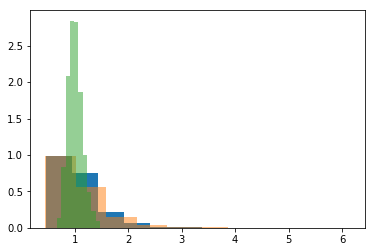

In [41]:
# decay time
plt.hist(result_array.T[0],normed=True)
plt.hist(result_array.T[4],normed=True,alpha=0.5)
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.5)
print(result_array.T[0].std())
print(np.median(result_array.T[1]))
print(result_array.T[4].std())
print(np.median(result_array.T[5]))
print(result_Bayes_array.T[2].std())

(0.3250915862405041, 4.7922377500687977e-26)


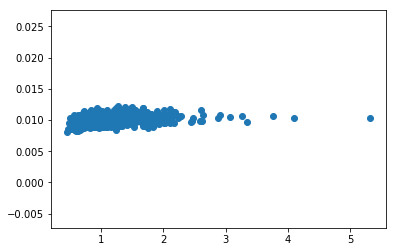

In [47]:
plt.scatter(result_array.T[0],result_Bayes_array.T[1])
print(pearsonr(result_array.T[0],result_Bayes_array.T[1]))

(0.28443078819002099, 4.5846101053696363e-20)


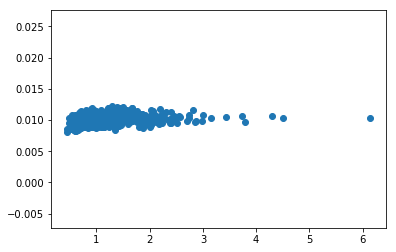

In [48]:
plt.scatter(result_array.T[4],result_Bayes_array.T[1])
print(pearsonr(result_array.T[4],result_Bayes_array.T[1]))

0.168238505342
0.00981292807328
0.183156196442
0.0119336580343
0.136438340708
0.00999652478162


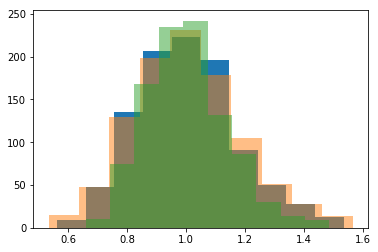

In [44]:
# amplitude
plt.hist(result_array.T[2])
plt.hist(result_array.T[6],alpha=0.5)
plt.hist(result_Bayes_array.T[0],alpha=0.5)
print(result_array.T[2].std())
print(np.median(result_array.T[3]))
print(result_array.T[6].std())
print(np.median(result_array.T[7]))
print(result_Bayes_array.T[0].std())
print(result_Bayes_array.T[1].mean())

(0.83102546321897186, 1.7773210631262675e-256)


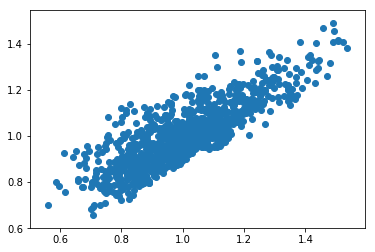

In [49]:
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))

(0.7708808554121469, 1.0766958774923144e-197)


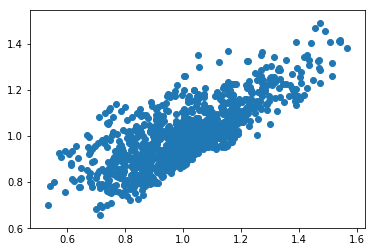

In [50]:
plt.scatter(result_array.T[6],result_Bayes_array.T[0])
print(pearsonr(result_array.T[6],result_Bayes_array.T[0]))